In [1]:
import pamtra2
import collections
import numpy as np
import pandas as pn
import xarray as xr
from collections import OrderedDict
from copy import deepcopy, copy
import toolz
import collections
import matplotlib.pyplot as plt

try:
    %matplotlib inline
except:
    pass

# create Profile

In [2]:
additionalDims = collections.OrderedDict()
additionalDims['time'] = pn.date_range('2016-01-01','2016-01-05',freq='D')[:1]
nHeights = 10

pam2 = pamtra2.pamtra2(
    nLayer=nHeights,
    hydrometeors=['rain','snow'],
    additionalDims = additionalDims,
    frequencies = [35e9, 94e9],
)



In [3]:
pam2.profile

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, layer: 10, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, layer) float64 nan nan nan nan nan nan nan ...
    temperature          (time, layer) float64 nan nan nan nan nan nan nan ...
    pressure             (time, layer) float64 nan nan nan nan nan nan nan ...
    relativeHumidity     (time, layer) float64 nan nan nan nan nan nan nan ...
    horizontalWind       (time, layer) float64 nan nan nan nan nan nan nan ...
    verticalWind         (time, layer) float64 nan nan nan nan nan nan nan ...
    eddyDissipationRate  (time, layer) float64 nan nan nan nan nan nan nan ...
    waterContent         (time, layer, hydrometeor) float64 nan nan nan nan ...
    

Fill with some dummie values

In [4]:

pam2.profile.height[:] = np.linspace(0,1000,nHeights)
pam2.profile.temperature[:] = 250 
pam2.profile.relativeHumidity[:] = 90
pam2.profile.pressure[:] = 100000
pam2.profile.eddyDissipationRate[:] = 1e-4
pam2.profile.horizontalWind[:] = 0



pam2.profile.waterContent.values[:] = 0
#rain
pam2.profile.waterContent.values[...,5:8,0] = 1e-4
#snow
pam2.profile.waterContent.values[...,5:8,1] = 2e-4



For testing, dask arrays are turned on by chunking.

In [5]:
pam2.profile = pam2.profile.chunk({'time':1, 'hydrometeor':1, 'frequency':1})

In [6]:
pam2.addMissingVariables()
pam2.profile 

<xarray.customProfile>
Dimensions:              (frequency: 2, hydrometeor: 2, layer: 10, time: 1)
Coordinates:
  * time                 (time) datetime64[ns] 2016-01-01
  * layer                (layer) int64 0 1 2 3 4 5 6 7 8 9
  * hydrometeor          (hydrometeor) <U4 'rain' 'snow'
  * frequency            (frequency) float64 3.5e+10 9.4e+10
Data variables:
    height               (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    temperature          (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    pressure             (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    relativeHumidity     (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    horizontalWind       (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    verticalWind         (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1, 10)>
    eddyDissipationRate  (time, layer) float64 dask.array<shape=(1, 10), chunksize=(1

In [7]:
# # OR EASIER if desired: 
# pam2 = pamtra2.importers.profiles.usStandardAtmosphere(heigths)

# Describe Hydrometeors
To describe the hydrometeors, you can use functions, xr.DataArrays or scalars. Teh functions must support xr.DataArrays. The kwargs of the functions are gathered from (in this order)

1. pam2.hydrometors.name.profile variables (name must match). E.g. density (after it has been calculated) 
2. pam2.profile variables (name must match). E.g. temperature
3. Other provided kwargs (e.g. Dmin, DMax, N0 etc)
4. Default function arguments. Can be turned of with useFuncArgDefaults = False to make sure everything is explicitly covered.



In [8]:

pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidFixedDensity,
    name = 'rain', #or None, then str(index)
    nBins =40,
    sizeBounds = pamtra2.hydrometeors.size.linspaceBounds, 
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialN0WC, 
    aspectRatio = 1.0,
    mass = pamtra2.hydrometeors.mass.ellipsoid,
    density = pamtra2.hydrometeors.density.water,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.sphere,
    relativePermittivity = pamtra2.libs.refractiveIndex.water.turner_kneifel_cadeddu, #replace with refractiveIndex.water.Turner.n
    scattering = pamtra2.hydrometeors.scattering.Rayleigh,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.khvorostyanov01_drops,
    Dmin  = 1e-6,
    Dmax  = 1e-2,
    N0 =  8e6,
    useFuncArgDefaults = True,
)


sizeBounds <function linspaceBounds at 0x7f06da4d3048>
callable
sizeCenter <function boundsToMid at 0x7f06da4d3158>
callable
sizeBoundsWidth <function boundsWidth at 0x7f06da4d31e0>
callable
aspectRatio 1.0
not callable 1.0
density 1000.0
not callable 1000.0
mass <function ellipsoid at 0x7f06da4d3510>
callable
crossSectionArea <function sphere at 0x7f06da4d3b70>
callable
sizeDistribution <function exponentialN0WC at 0x7f06da4d38c8>
callable
relativePermittivity <function turner_kneifel_cadeddu at 0x7f06da4c22f0>
callable
scattering <function Rayleigh at 0x7f06da4d7048>
callable
fallVelocity <function khvorostyanov01_drops at 0x7f06da4d7158>
callable
nBins 40
not callable 40
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
N0 8000000.0
not callable 8000000.0


/home/vagrant/miniconda/lib/python3.6/site-packages/pamtra2-0.1-py3.6-linux-x86_64.egg/pamtra2/hydrometeors/sizeDistribution.py:303: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '
/home/vagrant/miniconda/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


Note that there is a warning in case not all arguments are used

In [9]:
pam2.describeHydrometeor(
    pamtra2.hydrometeors.softEllipsoidMassSize,
    name='snow',
    nBins = 20,
    sizeBounds=pamtra2.hydrometeors.size.logspaceBounds, #function/object to call for getting sizes
    sizeCenter = pamtra2.hydrometeors.size.boundsToMid,
    sizeBoundsWidth = pamtra2.hydrometeors.size.boundsWidth,
    sizeDistribution = pamtra2.hydrometeors.sizeDistribution.exponentialFieldWC,
    aspectRatio = 0.6,
    crossSectionArea = pamtra2.hydrometeors.crossSectionArea.powerLaw,
    mass = pamtra2.hydrometeors.mass.powerLaw,
    density = pamtra2.hydrometeors.density.softEllipsoid,
    #to do: adapt refractiveIndex routine so that mixing and RI are treated separately. 
    relativePermittivity = pamtra2.libs.refractiveIndex.snow.eps,
    scattering = pamtra2.hydrometeors.scattering.Mie,
    fallVelocity = pamtra2.hydrometeors.fallVelocity.heymsfield10_particles,
    Dmin = 1e-6,
    Dmax = 1e-2,
    massSizeA = 0.0121, 
    massSizeB = 1.9,
    areaSizeA = 0.4,
    areaSizeB = 1.8,
    minDensity = 100,
    bla = 12,
    useFuncArgDefaults = True,
    )


sizeBounds <function logspaceBounds at 0x7f06da4d30d0>
callable
sizeCenter <function boundsToMid at 0x7f06da4d3158>
callable
sizeBoundsWidth <function boundsWidth at 0x7f06da4d31e0>
callable
aspectRatio 0.6
not callable 0.6
mass <function powerLaw at 0x7f06da4d3488>
callable
density <function softEllipsoid at 0x7f06da4d3d08>
callable
crossSectionArea <function powerLaw at 0x7f06da4d3ae8>
callable
sizeDistribution <function exponentialFieldWC at 0x7f06da4d37b8>
callable
relativePermittivity <function eps at 0x7f06da4aed08>
callable
scattering <function Mie at 0x7f06da4d3f28>
callable
fallVelocity <function heymsfield10_particles at 0x7f06da4d70d0>
callable
nBins 20
not callable 20
Dmin 1e-06
not callable 1e-06
Dmax 0.01
not callable 0.01
massSizeA 0.0121
not callable 0.0121
massSizeB 1.9
not callable 1.9
areaSizeA 0.4
not callable 0.4
areaSizeB 1.8
not callable 1.8
minDensity 100
not callable 100
bla 12
not callable 12


/home/vagrant/miniconda/lib/python3.6/site-packages/pamtra2-0.1-py3.6-linux-x86_64.egg/pamtra2/hydrometeors/sizeDistribution.py:303: UserWarning: Truncation effect on the PSD are not considered. I.e., typically mass is lost!
  warnings.warn('Truncation effect on the PSD are not considered. '
/home/vagrant/miniconda/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/vagrant/miniconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping
/home/vagrant/miniconda/lib/python3.6/site-packages/pamtra2-0.1-py3.6-linux-x86_64.egg/pamtra2/hydrometeors/core.py:265: UserWarning: The following kwargs were NOT used: ['bla']
  '%s' % self._keysToBeUsed)


We have access to a lot of internal properties, like the fall velocity of particles

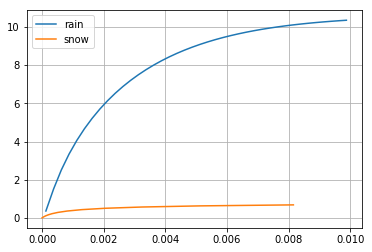

In [10]:
plt.plot(
    pam2.hydrometeors.rain.profile.sizeCenter,
    pam2.hydrometeors.rain.profile.fallVelocity.isel(layer=5,time=0),
    label = 'rain')
plt.plot(
    pam2.hydrometeors.snow.profile.sizeCenter,
    pam2.hydrometeors.snow.profile.fallVelocity.isel(layer=5,time=0),
    label = 'snow')
plt.legend()
plt.grid()


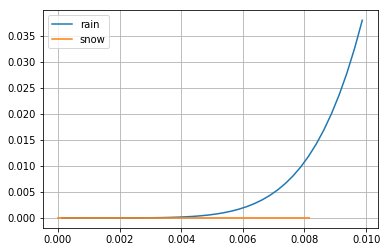

In [11]:
plt.plot(
    pam2.hydrometeors.rain.profile.sizeCenter,
    pam2.hydrometeors.rain.profile.backscatterCrossSection.isel(layer=5,time=0,frequency=0),
    label = 'rain')
plt.plot(
    pam2.hydrometeors.snow.profile.sizeCenter,
    pam2.hydrometeors.snow.profile.backscatterCrossSection.isel(layer=5,time=0,frequency=0),
    label = 'snow')
plt.legend()
plt.grid()


The profile arrays have been populated, but they contain daks arrays. These are only placeholders, they have not been calculated yet!

In [12]:
pam2.hydrometeors.rain.profile, pam2.hydrometeors.snow.profile

(<xarray.Dataset>
 Dimensions:                  (frequency: 2, layer: 10, sizeBin: 40, sizeBin1: 41, time: 1)
 Coordinates:
   * sizeBin                  (sizeBin) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 ...
   * sizeBin1                 (sizeBin1) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
   * time                     (time) datetime64[ns] 2016-01-01
   * layer                    (layer) int64 0 1 2 3 4 5 6 7 8 9
   * frequency                (frequency) float64 3.5e+10 9.4e+10
 Data variables:
     sizeBounds               (sizeBin1) float64 1e-06 0.000251 0.000501 ...
     sizeCenter               (sizeBin) float64 0.000126 0.000376 0.0006259 ...
     sizeBoundsWidth          (sizeBin) float64 0.00025 0.00025 0.00025 ...
     aspectRatio              float64 1.0
     density                  float64 1e+03
     mass                     (sizeBin) float64 1.047e-09 2.782e-08 1.284e-07 ...
     crossSectionArea         (sizeBin) float64 1.247e-08 1.11e-07 3.077e-07 ...
     sizeDistribution 

Force computation with e.g.
`pam2.hydrometeors.rain.profile.compute()` or `pam2.hydrometeors.rain.profile.to_netcdf()` or  or `pam2.hydrometeors.rain.profile.fallVelocity.plot()`

# Radar simulator


In [13]:


pam2.addInstrument(
    pamtra2.instruments.radar.dopplerRadarPamtra,
    name = 'test',
    frequencies = 3.5e+10,    
        radarMaxV=7.885,
        radarMinV=-7.885,
        radarAliasingNyquistInterv=1,
        radarNFFT=256,
        verbosity=0,
        radarAirmotion=True,
        radarAirmotionModel="constant",  # "constant","linear","step"
        radarAirmotionVmin=0,
        radarAirmotionVmax=0,
        radarAirmotionLinearSteps=30,
        radarAirmotionStepVmin=0.5,
        radarK2=0.93,         # dielectric constant |K|² (always for liquid water by convention) for the radar equation
        radarBeamwidthDeg=0.2,
        radarIntegrationTime=60,
        radarPNoise1000=-30,
        radarNAve=150,
        seed=0,
)

Again, the results are not estimated yet when using dask.

In [14]:
pam2.instruments.test.results


<xarray.Dataset>
Dimensions:                    (dopplerVelocity: 256, dopplerVelocityAliased: 768, frequency: 2, layer: 10, peak: 2, time: 1)
Coordinates:
  * frequency                  (frequency) float64 3.5e+10 9.4e+10
  * time                       (time) datetime64[ns] 2016-01-01
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9
  * dopplerVelocity            (dopplerVelocity) float64 -7.885 -7.823 ...
  * peak                       (peak) int64 1 2
Dimensions without coordinates: dopplerVelocityAliased
Data variables:
    specificAttenuation        (frequency, time, layer) float64 dask.array<shape=(2, 1, 10), chunksize=(1, 1, 10)>
    pathIntegratedAttBottomUp  (frequency, time, layer) float64 dask.array<shape=(2, 1, 10), chunksize=(1, 1, 10)>
    pathIntegratedAttTopDown   (frequency, time, layer) float64 dask.array<shape=(2, 1, 10), chunksize=(1, 1, 10)>
    radarIdealizedSpectrum     (dopplerVelocityAliased, time, layer, frequency) float64 dask.array<shape=(768

Do the numbers!

In [15]:
pam2.instruments.test.results.load()

/home/vagrant/miniconda/lib/python3.6/site-packages/dask/local.py:271: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/home/vagrant/miniconda/lib/python3.6/site-packages/pamtra2-0.1-py3.6-linux-x86_64.egg/pamtra2/libs/pyPamtraRadarMoments/core.py:169: RuntimeWarning: invalid value encountered in log10
  noiseMean = 10*np.log10(momentsSpecNoiseMean * radarNFFT * del_v)


<xarray.Dataset>
Dimensions:                    (dopplerVelocity: 256, dopplerVelocityAliased: 768, frequency: 2, layer: 10, peak: 2, time: 1)
Coordinates:
  * frequency                  (frequency) float64 3.5e+10 9.4e+10
  * time                       (time) datetime64[ns] 2016-01-01
  * layer                      (layer) int64 0 1 2 3 4 5 6 7 8 9
  * dopplerVelocity            (dopplerVelocity) float64 -7.885 -7.823 ...
  * peak                       (peak) int64 1 2
Dimensions without coordinates: dopplerVelocityAliased
Data variables:
    specificAttenuation        (frequency, time, layer) float64 5.399e-05 ...
    pathIntegratedAttBottomUp  (frequency, time, layer) float64 0.005999 ...
    pathIntegratedAttTopDown   (frequency, time, layer) float64 0.3039 ...
    radarIdealizedSpectrum     (dopplerVelocityAliased, time, layer, frequency) float64 0.0 ...
    radarSpectrum              (dopplerVelocity, time, layer, frequency) float64 -9.999e+03 ...
    radarReflectivity          (

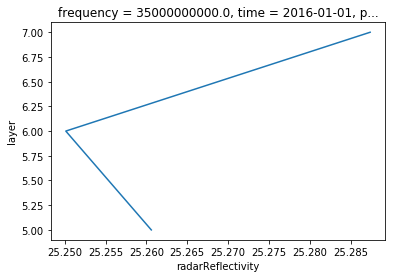

In [16]:
pam2.instruments.test.results.radarReflectivity.isel(peak=0,frequency=0).plot(y='layer')

